## test해볼것
[x] 이진화 한걸로 train  
[ ] 원본+이진화로 train  
    - 데이터 나눠서 이진화 후 원본 훈련 o
    - 데이터 나눠서 원본 후 이진화 훈련
    - 데이터 합쳐서 이진화 후 원본 훈련
    - 데이터 합쳐서 원본 후 이진화 훈련
    - 데이터 랜덤으로
    
    
---
- test 데이터는 2가지 : 원본일때 or 이진화한 test 이미지: 원본으로하기!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

## Python import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf

from keras import layers
from keras import models
from keras import Input
from keras.models import Model
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, Dropout
from keras.utils import to_categorical
from keras import regularizers # L2규제

from tensorflow.keras.preprocessing.image import ImageDataGenerator # data augmentation
from tensorflow.keras.callbacks import LearningRateScheduler # callbacks 설정

from tqdm.notebook import tqdm # 모델학습 진행 시간 파악
import random # random seed를 뽑을때 사용

In [2]:
#opencv
import cv2

#gpu사용
config= tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True

In [3]:
print(tf.__version__)

2.3.0


## Load Data

In [4]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

## EDA

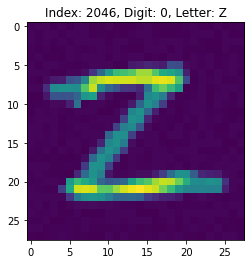

In [5]:
idx = 2046
img = train.loc[idx, '0':].values.reshape(28, 28).astype(int)
digit = train.loc[idx, 'digit']
letter = train.loc[idx, 'letter']

plt.title('Index: %i, Digit: %s, Letter: %s'%(idx, digit, letter))
plt.imshow(img)
plt.show()

## Train model

In [6]:
x_train = train.drop(['id', 'digit', 'letter'], axis=1).values
x_train = x_train.reshape(-1, 28, 28, 1)
x_edit=x_train
x_train = x_train/255

y = train['digit']
y_train = np.zeros((len(y), len(y.unique())))
for i, digit in enumerate(y):
    y_train[i, digit] = 1

In [7]:
threshold=140 #임계값
for i in range(0,2048):
    for j in range(0,28):
        for k in range(0,28):
            if(x_edit[i][j][k][0]<=threshold):
                x_edit[i][j][k][0]=0
            else:
                x_edit[i][j][k][0]=255/255

In [8]:
#결과확인
print(x_edit[2046][7])
print(x_train[2046][7])

[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]
[[0.00784314]
 [0.        ]
 [0.02352941]
 [0.07058824]
 [0.07843137]
 [0.23921569]
 [0.26666667]
 [0.43921569]
 [0.83529412]
 [0.89803922]
 [0.92941176]
 [0.92156863]
 [0.91764706]
 [0.92156863]
 [0.88627451]
 [0.88627451]
 [0.94117647]
 [0.95294118]
 [0.93333333]
 [0.70980392]
 [0.21960784]
 [0.        ]
 [0.01568627]
 [0.00784314]
 [0.01176471]
 [0.        ]
 [0.00392157]
 [0.00784314]]


---

In [9]:
x_train1 = np.repeat(x_train, 3, axis=1)
x_train2 = np.repeat(x_train1, 3, axis=2)
x_edit1=np.repeat(x_edit, 3, axis=1)
x_edit2=np.repeat(x_edit1, 3, axis=2)

In [10]:
print(x_train2.shape, x_edit2.shape)

(2048, 84, 84, 1) (2048, 84, 84, 1)


In [11]:
def create_cnn_model():
    inputs = Input(shape = (84,84,1))
    
    bn = tf.keras.layers.BatchNormalization()(inputs)
    conv = tf.keras.layers.Conv2D(64, kernel_size=5, strides=1, padding='same', activation='relu')(bn)
    bn = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(64, kernel_size=2, strides=1, padding='same', activation='relu')(bn)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(conv)
    
    do=tf.keras.layers.Dropout(0.4)(pool)
    
    bn = tf.keras.layers.BatchNormalization()(do)
    conv = tf.keras.layers.Conv2D(128, kernel_size=5, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    bn = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(128, kernel_size=2, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(conv)

    do=tf.keras.layers.Dropout(0.4)(pool)
    
    bn = tf.keras.layers.BatchNormalization()(do)
    conv = tf.keras.layers.Conv2D(256, kernel_size=2, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    bn = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(256, kernel_size=2, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(conv)

    flatten = tf.keras.layers.Flatten()(pool)

    bn = tf.keras.layers.BatchNormalization()(flatten)
    dense = tf.keras.layers.Dense(1000, activation='relu')(bn)

    bn = tf.keras.layers.BatchNormalization()(dense)
    outputs = tf.keras.layers.Dense(10, activation='softmax')(bn)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [12]:
create_cnn_model().summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 84, 84, 1)]       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 84, 84, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 84, 84, 64)        1664      
_________________________________________________________________
batch_normalization_1 (Batch (None, 84, 84, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 84, 84, 64)        16448     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 42, 42, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 42, 42, 64)       

In [15]:
#원본 이미지 학습
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

# 이미지 증식 사용
datagen = ImageDataGenerator(
    rotation_range=10,  
    zoom_range = 0.1, 
    width_shift_range=0.1,
    height_shift_range=0.1)

model = create_cnn_model() #앞에거에 이어서 학습 할땐 주석처리!
epochs=200

#model.fit(x_train, y_train, epochs=50)

history = model.fit(
  datagen.flow(x_train2, y_train, batch_size=16),
  epochs=epochs, 
  steps_per_epoch = x_train2.shape[0]//16,
  callbacks=[annealer], 
  verbose = 1
)

Epoch 1/200
128/128 [==============================] - 3s 23ms/step - loss: 3.8416 - accuracy: 0.3232
Epoch 2/200
128/128 [==============================] - 3s 23ms/step - loss: 2.2269 - accuracy: 0.5112
Epoch 3/200
128/128 [==============================] - 3s 23ms/step - loss: 2.0830 - accuracy: 0.5391
Epoch 4/200
128/128 [==============================] - 3s 23ms/step - loss: 1.8951 - accuracy: 0.5947
Epoch 5/200
128/128 [==============================] - 3s 23ms/step - loss: 1.7710 - accuracy: 0.6245
Epoch 6/200
128/128 [==============================] - 3s 23ms/step - loss: 1.6860 - accuracy: 0.6411
Epoch 7/200
128/128 [==============================] - 3s 23ms/step - loss: 1.5358 - accuracy: 0.6929
Epoch 8/200
128/128 [==============================] - 3s 23ms/step - loss: 1.4324 - accuracy: 0.7109
Epoch 9/200
128/128 [==============================] - 3s 23ms/step - loss: 1.3603 - accuracy: 0.7451
Epoch 10/200
128/128 [==============================] - 3s 23ms/step - loss: 1.293

128/128 [==============================] - 3s 21ms/step - loss: 0.2451 - accuracy: 0.9805
Epoch 78/200
128/128 [==============================] - 3s 21ms/step - loss: 0.2371 - accuracy: 0.9814
Epoch 79/200
128/128 [==============================] - 3s 21ms/step - loss: 0.2228 - accuracy: 0.9897
Epoch 80/200
128/128 [==============================] - 3s 21ms/step - loss: 0.2335 - accuracy: 0.9824
Epoch 81/200
128/128 [==============================] - 3s 21ms/step - loss: 0.2203 - accuracy: 0.9873
Epoch 82/200
128/128 [==============================] - 3s 21ms/step - loss: 0.2325 - accuracy: 0.9824
Epoch 83/200
128/128 [==============================] - 3s 21ms/step - loss: 0.2254 - accuracy: 0.9873
Epoch 84/200
128/128 [==============================] - 3s 22ms/step - loss: 0.2302 - accuracy: 0.9863
Epoch 85/200
128/128 [==============================] - 3s 21ms/step - loss: 0.2280 - accuracy: 0.9834
Epoch 86/200
128/128 [==============================] - 3s 21ms/step - loss: 0.2262 - 

128/128 [==============================] - 3s 22ms/step - loss: 0.1987 - accuracy: 0.9888
Epoch 156/200
128/128 [==============================] - 3s 21ms/step - loss: 0.2025 - accuracy: 0.9878
Epoch 157/200
128/128 [==============================] - 3s 22ms/step - loss: 0.2063 - accuracy: 0.9878
Epoch 158/200
128/128 [==============================] - 3s 21ms/step - loss: 0.2059 - accuracy: 0.9878
Epoch 159/200
128/128 [==============================] - 3s 22ms/step - loss: 0.2031 - accuracy: 0.9912
Epoch 160/200
128/128 [==============================] - 3s 22ms/step - loss: 0.1967 - accuracy: 0.9912
Epoch 161/200
128/128 [==============================] - 3s 22ms/step - loss: 0.1951 - accuracy: 0.9937
Epoch 162/200
128/128 [==============================] - 3s 22ms/step - loss: 0.1979 - accuracy: 0.9907
Epoch 163/200
128/128 [==============================] - 3s 22ms/step - loss: 0.1951 - accuracy: 0.9912
Epoch 164/200
128/128 [==============================] - 3s 22ms/step - loss: 

In [16]:
# 이진화 이미지 학습
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

# 이미지 증식 사용
datagen = ImageDataGenerator(
    rotation_range=10,  
    zoom_range = 0.1, 
    width_shift_range=0.1,
    height_shift_range=0.1)

#model = create_cnn_model()
epochs=200

#model.fit(x_train, y_train, epochs=50)

history = model.fit(
  datagen.flow(x_edit2, y_train, batch_size=16),
  epochs=epochs, 
  steps_per_epoch = x_edit2.shape[0]//16,
  callbacks=[annealer], 
  verbose = 1
)

Epoch 1/200
128/128 [==============================] - 3s 22ms/step - loss: 3.0430 - accuracy: 0.3301
Epoch 2/200
128/128 [==============================] - 3s 22ms/step - loss: 2.1567 - accuracy: 0.4141
Epoch 3/200
128/128 [==============================] - 3s 22ms/step - loss: 1.9548 - accuracy: 0.4438
Epoch 4/200
128/128 [==============================] - 3s 21ms/step - loss: 1.7641 - accuracy: 0.4771
Epoch 5/200
128/128 [==============================] - 3s 22ms/step - loss: 1.6679 - accuracy: 0.5068
Epoch 6/200
128/128 [==============================] - 3s 21ms/step - loss: 1.5801 - accuracy: 0.5078
Epoch 7/200
128/128 [==============================] - 3s 22ms/step - loss: 1.5223 - accuracy: 0.5449
Epoch 8/200
128/128 [==============================] - 3s 22ms/step - loss: 1.5014 - accuracy: 0.5396
Epoch 9/200
128/128 [==============================] - 3s 22ms/step - loss: 1.4457 - accuracy: 0.5547
Epoch 10/200
128/128 [==============================] - 3s 21ms/step - loss: 1.406

128/128 [==============================] - 3s 21ms/step - loss: 0.5367 - accuracy: 0.8608
Epoch 81/200
128/128 [==============================] - 3s 22ms/step - loss: 0.5562 - accuracy: 0.8516
Epoch 82/200
128/128 [==============================] - 3s 21ms/step - loss: 0.5177 - accuracy: 0.8657
Epoch 83/200
128/128 [==============================] - 3s 22ms/step - loss: 0.5245 - accuracy: 0.8555
Epoch 84/200
128/128 [==============================] - 3s 22ms/step - loss: 0.5012 - accuracy: 0.8604
Epoch 85/200
128/128 [==============================] - 3s 22ms/step - loss: 0.5521 - accuracy: 0.8457
Epoch 86/200
128/128 [==============================] - 3s 21ms/step - loss: 0.5410 - accuracy: 0.8457
Epoch 87/200
128/128 [==============================] - 3s 22ms/step - loss: 0.5198 - accuracy: 0.8486
Epoch 88/200
128/128 [==============================] - 3s 22ms/step - loss: 0.5166 - accuracy: 0.8662
Epoch 89/200
128/128 [==============================] - 3s 22ms/step - loss: 0.5285 - 

128/128 [==============================] - 3s 22ms/step - loss: 0.5032 - accuracy: 0.8657
Epoch 159/200
128/128 [==============================] - 3s 21ms/step - loss: 0.5068 - accuracy: 0.8677
Epoch 160/200
128/128 [==============================] - 3s 22ms/step - loss: 0.4906 - accuracy: 0.8643
Epoch 161/200
128/128 [==============================] - 3s 22ms/step - loss: 0.4908 - accuracy: 0.8701
Epoch 162/200
128/128 [==============================] - 3s 21ms/step - loss: 0.4838 - accuracy: 0.8750
Epoch 163/200
128/128 [==============================] - 3s 22ms/step - loss: 0.4929 - accuracy: 0.8721
Epoch 164/200
128/128 [==============================] - 3s 21ms/step - loss: 0.5005 - accuracy: 0.8643
Epoch 165/200
128/128 [==============================] - 3s 21ms/step - loss: 0.4862 - accuracy: 0.8706
Epoch 166/200
128/128 [==============================] - 3s 21ms/step - loss: 0.5003 - accuracy: 0.8638
Epoch 167/200
128/128 [==============================] - 3s 22ms/step - loss: 

## Predict

In [24]:
x_test = test.drop(['id', 'letter'], axis=1).values
x_test = x_test.reshape(-1, 28, 28, 1)
x_t_edit=x_test
x_test = x_test/255

In [25]:
x_test1 = np.repeat(x_test, 3, axis=1)
x_test2 = np.repeat(x_test1, 3, axis=2)

In [26]:
submission = pd.read_csv('data/submission.csv')
submission['digit'] = np.argmax(model.predict(x_test2), axis=1)
submission.head(50)

,id,digit
0,2049,1
1,2050,6
2,2051,0
3,2052,0
4,2053,1
5,2054,0
6,2055,7
7,2056,6
8,2057,1
9,2058,1


In [20]:
submission.to_csv('원본-이진화 두 번 이어서 훈련_이진화xtest.csv', index=False)

---

In [27]:
threshold=140 #임계값
for i in range(0,20480):
    if(i%3000==0):
        print(i)
    for j in range(0,28):
        for k in range(0,28): 
            if(x_t_edit[i][j][k][0]<=threshold):
                x_t_edit[i][j][k][0]=0
            else:
                x_t_edit[i][j][k][0]=255/255

0
3000
6000
9000
12000
15000
18000


In [28]:
x_t_edit1 = np.repeat(x_t_edit, 3, axis=1)
x_t_edit2 = np.repeat(x_t_edit1, 3, axis=2)

In [29]:
submission2 = pd.read_csv('data/submission.csv')
submission2['digit'] = np.argmax(model.predict(x_t_edit2), axis=1)
submission2.head(50)

,id,digit
0,2049,1
1,2050,0
2,2051,3
3,2052,0
4,2053,3
5,2054,8
6,2055,5
7,2056,3
8,2057,4
9,2058,4


# 저장하기전 head확인하고 아래실행

---

---

---

---

---

---

In [30]:
#head만봐도 정확도가 너무 안좋아서 따로 저장 안하는게 나을듯?
submission2.to_csv('원본-이진화 두 번 이어서 훈련_이진화otest.csv', index=False)